<a href="https://colab.research.google.com/github/bintangnabiil/Deep_Learning/blob/main/Deep_Learning_Week1_income.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch [1/20], Loss: 634.2858
Epoch [2/20], Loss: 592.4932
Epoch [3/20], Loss: 585.8460
Epoch [4/20], Loss: 581.6662
Epoch [5/20], Loss: 578.7966
Epoch [6/20], Loss: 576.3017
Epoch [7/20], Loss: 575.5764
Epoch [8/20], Loss: 573.1074
Epoch [9/20], Loss: 572.0336
Epoch [10/20], Loss: 569.9333
Epoch [11/20], Loss: 566.6362
Epoch [12/20], Loss: 566.7173
Epoch [13/20], Loss: 565.5525
Epoch [14/20], Loss: 563.9752
Epoch [15/20], Loss: 562.6736
Epoch [16/20], Loss: 562.0189
Epoch [17/20], Loss: 560.3871
Epoch [18/20], Loss: 560.8612
Epoch [19/20], Loss: 558.6089
Epoch [20/20], Loss: 558.7124
🔹 Akurasi: 0.5958
🔹 Presisi: 0.5053
🔹 Recall: 0.4160
🔹 F1-Score: 0.3671
🔹 AUC: 0.7856


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


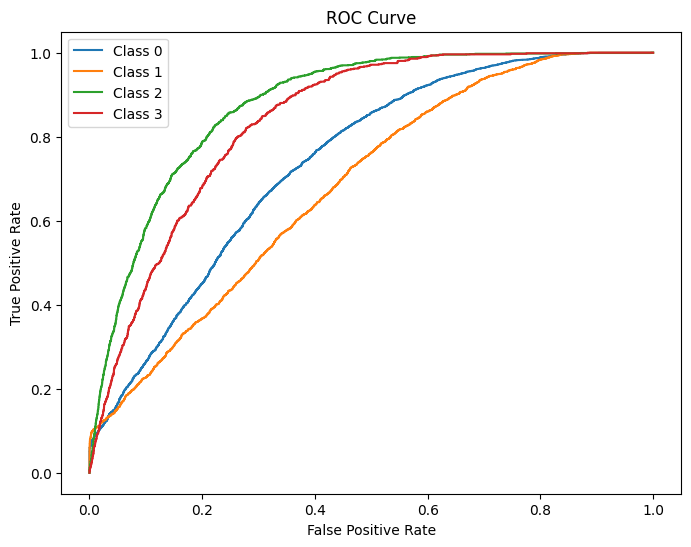

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# 🚀 **1. Load Dataset**
df = pd.read_csv("income.csv")

# 🚀 **2. Preprocessing**
# Pisahkan fitur numerik & kategori
categorical_features = df.select_dtypes(include=["object"]).columns.tolist()
numerical_features = df.select_dtypes(exclude=["object"]).columns.tolist()

# Target harus diproses terpisah
categorical_features.remove("income")

# Label Encoding untuk target
le = LabelEncoder()
df["income"] = le.fit_transform(df["income"])

# One-Hot Encoding untuk fitur kategori
df_encoded = pd.get_dummies(df, columns=categorical_features)

# Pisahkan fitur & target
X = df_encoded.drop(columns=["income"])  # Fitur
y = df_encoded["income"]  # Target

# Normalisasi fitur numerik saja
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Convert ke tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)  # Multiclass → gunakan `long`
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# 🚀 **3. Bangun Model dengan PyTorch**
class IncomeNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(IncomeNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, output_dim)  # Output multiclass
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # Tanpa Softmax di sini (karena pakai CrossEntropyLoss)
        return x

# 🚀 **4. Inisialisasi Model**
input_dim = X_train.shape[1]
output_dim = len(np.unique(y))  # Jumlah kelas unik
model = IncomeNet(input_dim, output_dim)

# Loss Function & Optimizer
criterion = nn.CrossEntropyLoss()  # Untuk multiclass classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 🚀 **5. Training Model**
epochs = 20
batch_size = 64

train_data = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss:.4f}")

# 🚀 **6. Evaluasi Model**
model.eval()
with torch.no_grad():
    y_test_logits = model(X_test_tensor)
    y_test_pred_prob = F.softmax(y_test_logits, dim=1).numpy()  # Probabilitas
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  # Kelas prediksi

# 🚀 **7. Hitung Metrik Evaluasi**
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average="macro")
recall = recall_score(y_test, y_test_pred, average="macro")
f1 = f1_score(y_test, y_test_pred, average="macro")

# AUC untuk multiclass → Binarisasi y_test
y_test_bin = label_binarize(y_test, classes=np.unique(y))
auc = roc_auc_score(y_test_bin, y_test_pred_prob, multi_class="ovr")

print(f"🔹 Akurasi: {accuracy:.4f}")
print(f"🔹 Presisi: {precision:.4f}")
print(f"🔹 Recall: {recall:.4f}")
print(f"🔹 F1-Score: {f1:.4f}")
print(f"🔹 AUC: {auc:.4f}")

# 🚀 **8. Plot ROC Curve**
plt.figure(figsize=(8, 6))
for i in range(output_dim):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f"Class {i}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

#Persamaan Matematika
##1. Neural Network
Neaural Network bekerja dengan melakukan transformasi linear terhadap input data dan menerapkan fungsi aktivasi untuk memperkenalkan non-linearitas. Jika kita memiliki input $X$ dengan bobot $W$ dan bias $b$, maka output linear dari setiap neuron pada lapisan tersembunyi dihitung dengan:

$Z = XW+b$

Di mana:
- $X$ = matriks fitur.
- $W$ = matriks bobot.
- $b$ = vektor bias.<br><br>

##2. ReLU (Rectified Linear Unit)
Fungsi ReLU digunakan  karena dapat membantu mengatasi masalah vanishing gradient yang sering terjadi pada fungsi aktivasi lain seperti sigmoid atau tanh.

$A = max(0,Z)$<br><br>

##3. Fungsi Aktivasi Softmax
Untuk lapisan output, karena kita melakukan klasifikasi, kita menggunakan fungsi aktivasi softmax yang mengubah keluaran dari lapisan terakhir menjadi probabilitas:

$P(y_i) = \frac{e^{Z_i}}{\sum_j e^{Z_j}}$

Di mana:
- $P(y_i)$ = probabilitas bahwa sampel termasuk dalam kelas $i$. Fungsi ini memastikan bahwa semua output berada dalam rentang $[0,1]$ dan jumlahnya selalu sama dengan 1.<br><br>

##4. Categorical Cross-Entropy Loss
Model menggunakan fungsi loss untuk mengukur seberapa jauh prediksi model dari nilai sebenarnya. Karena kita menghadapi kasus multiclass classification, kita menggunakan categorical cross-entropy loss:

$L = -\sum_i y_ilog(\hat{y}_i)$

Di mana:
- $y_i$ = label sebenarnya dalam bentuk one-hot encoding.
- $\hat{y}_i$ = adalah probabilitas prediksi model untuk kelas $i$.

Loss ini akan lebih tinggi jika model memprediksi probabilitas yang salah untuk kelas yang benar.<br><br>

##5. Backpropagation
Untuk memperbarui bobot model dan mengoptimalkan loss, kita menggunakan backpropagation dengan algoritma gradient descent. Dalam setiap iterasi, bobot diperbarui dengan persamaan:

$W := W-η\frac{∂L}{∂W}$

Di mana:
- $η$ = learning rate.
- $\frac{∂L}{∂W}$ = turunan dari loss terhadap bobot. Turunan ini dihitung menggunakan aturan rantai dalam kalkulus, dan menentukan arah perubahan bobot agar loss berkurang secara bertahap.

##6. Adam Optimizer
Model ini menggunakan varian gradient descent yang lebih canggih, yaitu Adam optimizer, yang menggabungkan momentum dan adaptive learning rate untuk mempercepat konvergensi:

$m_t = β_tm_t+(1-β_1)g_t$

$v_t = β_2v_{t-1}+(1-β_2)g_t^2$

Di mana:
- $g_t$ = gradien loss pada iterasi ke $t$.
- $m_t$ =  momentum untuk mempercepat arah perubahan bobot.
- $v_t$ = rata-rata gradien kuadrat untuk mengatur learning rate secara adaptif.

##7. Akurasi
Akurasi mengukur proporsi prediksi yang benar terhadapa seluruh data yang diuji. Accuracy yang bagus untuk dataset yang seimbang, tetapi kurang optimal jika dataset memiliki distribusi kelas yang tidak merata.

$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$

- TP (True Postive) = data positif yang diklasifikasikan sebagai positif.
- TN (True Negative) = data negatif yang diklasifikasikan sebagai negatif.
- FP (False Positive) = data negatif yang diklasifikasikan sebagai positif.
- FN (False Negative) = data negatif yang diklasifikasikan sebagai negatif.<br><br>

##8. Precision
Precision mengukur seberapa akurat model dalam memprediksi positif. Presisi tinggi berarti model jarang memberikan prediksi positif yang salah.

$Precision = \frac{TP}{TP + FP}$<br><br>

##9. Recall
REcall mengukur seberapa banyak data positif yang berhasil dideteksi oleh model. Recall yang tinggi berarti model jarang melewatkan data positif yang seharusnya diklarifikasikan dengan benar.

$Recall = \frac{TP}{TP+FN}$ <br><br>

##10. F1-Score
F1-Score adalah rata-rata harmonik antara precision dan recall. F1-score berguna jika dataset memiliki distribusi kelas yang tidak seimbang, karena menggabungkan keunggulan dari precision dan recall.

$F1 = 2 \times\frac{Precision\times Recall}{Precision+Recall}$ <br><br>

##11. Area Under Curve (AUC) dan Reciever Operating Characteristic (ROC)
AUC dan ROC digunakan untuk mengukur seberapa baik model dapat membedakan antara kelas yang berbeda. Semakin tinggi nilai AUC, semakin baik model dalam membedakan kelas. Untuk model ini, perhitungan AUC dilakukan dengan metode One-Versus-Rest (OVR), yang membandingkan setiap kelas dengan kelas lainnya.
